In [1]:
import sys
sys.path.append('..')
from data_utils import *

import torch
import numpy as np
import pickle
from torch.utils.data import DataLoader, random_split
from torch.utils.data import Subset
from transformer import *
import importlib
import wandb
import torch.optim as optim
from torch.optim.lr_scheduler import SequentialLR, LinearLR, CosineAnnealingLR
import matplotlib.gridspec as gridspec

import matplotlib.pyplot as plt

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # if using CUDA

### Load and Inspect the Data

In [2]:
# Loading in data
load_wfs = np.load('/sdf/home/c/carsmith/sdf_data/flash_detection_data/flash_files/delay_200ks/2_8.npy', allow_pickle=True) # array of shape (2519, 5, 250, 250)
dataset = WaveformDataset(load_wfs.item())

g = torch.Generator()
g.manual_seed(seed)

# Splitting data
val_ratio = 0.1
test_ratio = 0.0
total_size = len(dataset)
val_size = int(total_size * val_ratio)
test_size = int(total_size * test_ratio)
train_size = total_size - val_size - test_size
print(f"split sizes: {train_size, val_size, test_size}")
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size], generator=g)

batch_size = 25

def custom_collate_fn(batch):
    """
    Custom collate function for WaveformDataset.
    Each item in batch is a tuple: (waveform, arrival_time).
    Returns:
        waveforms: Tensor of shape (batch_size, waveform_length)
        arrival_times: Tensor of shape (batch_size,) or (batch_size, 1)
        hit_times: Tensor of shape (?) with a list of hit times per sample
    """
    waveforms, arrival_times, hit_times, photon_bins, photon_list = zip(*batch)
    waveforms = torch.stack(waveforms, dim=0)

     # Normalizing waveforms
    waveforms = (waveforms - waveforms.mean(dim=1, keepdim=True)) / (waveforms.std(dim=1, keepdim=True) + 1e-8)
    waveforms = waveforms.unsqueeze(1)  # add channel dimension [B,1,L]

    # for binary classification
    arrival_times = torch.stack(arrival_times, dim=0)
    arrival_times = arrival_times.unsqueeze(1) # adding channel dimension
    photon_bins = torch.stack(photon_bins, dim=0)
    photon_bins = photon_bins.unsqueeze(1)

    # for regression, just use hit times
    hit_times = [item[2] for item in batch]
    hit_times = torch.tensor(hit_times)
    photon_list = [item[4] for item in batch]
    photon_list = torch.tensor(photon_list)
    
    return waveforms, arrival_times, hit_times, photon_bins, photon_list
    

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    generator=g,
    collate_fn=custom_collate_fn,
    num_workers=0,
    pin_memory=False,
    drop_last=False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=custom_collate_fn,
    num_workers=0,
    pin_memory=False,
    drop_last=False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=custom_collate_fn,
    num_workers=0,
    pin_memory=False,
    drop_last=False
)

split sizes: (180000, 20000, 0)


hit_times: torch.Size([25, 8])
torch.Size([25, 1, 8000])
torch.Size([25, 1, 8000])


/lscratch/carsmith/tmp/ipykernel_1140191/1004424815.py:44: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  hit_times = torch.tensor(hit_times)


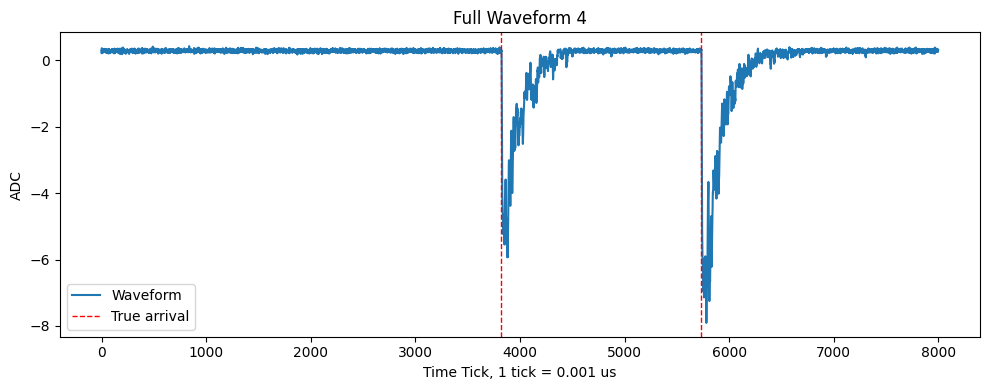

In [3]:
# Inspecting data
waveforms, arrival_times, hit_times, photon_bins, photon_list = next(iter(train_loader))
print(f"hit_times: {hit_times.shape}")
print(waveforms.shape)
print(arrival_times.shape)
ticks = np.arange(waveforms[0].shape[1])

waveform_id = 4
wf = waveforms[waveform_id]

ticks = torch.arange(wf.shape[-1])  # assume ticks = [0, 1, ..., length-1]
wf = wf.squeeze(0)  # shape: [length]

plt.figure(figsize = (10, 4))
plt.plot(ticks, wf, alpha=1, label='Waveform')

# FOR MULTIPLE HITS!
for j, t in enumerate(hit_times[waveform_id]):
    if t < 0:
        pass
    else:
        plt.axvline(
            x=t.item(), 
            color='r', 
            linestyle='--', 
            linewidth=1, 
            label='True arrival' if j == 0 else ""
        )
        
plt.title(f"Full Waveform {waveform_id}")
plt.xlabel(f"Time Tick, 1 tick = 0.001 us")
plt.ylabel("ADC")
plt.legend()
plt.tight_layout()
plt.show()

### Visualize the Positional Encoding
- Input has 3 dimensions: `[batch_size, channel, window_length]`
- Positional encoding only depends on the bin index in the `window_length` dimension

In [4]:
print(waveforms.shape)

torch.Size([25, 1, 8000])


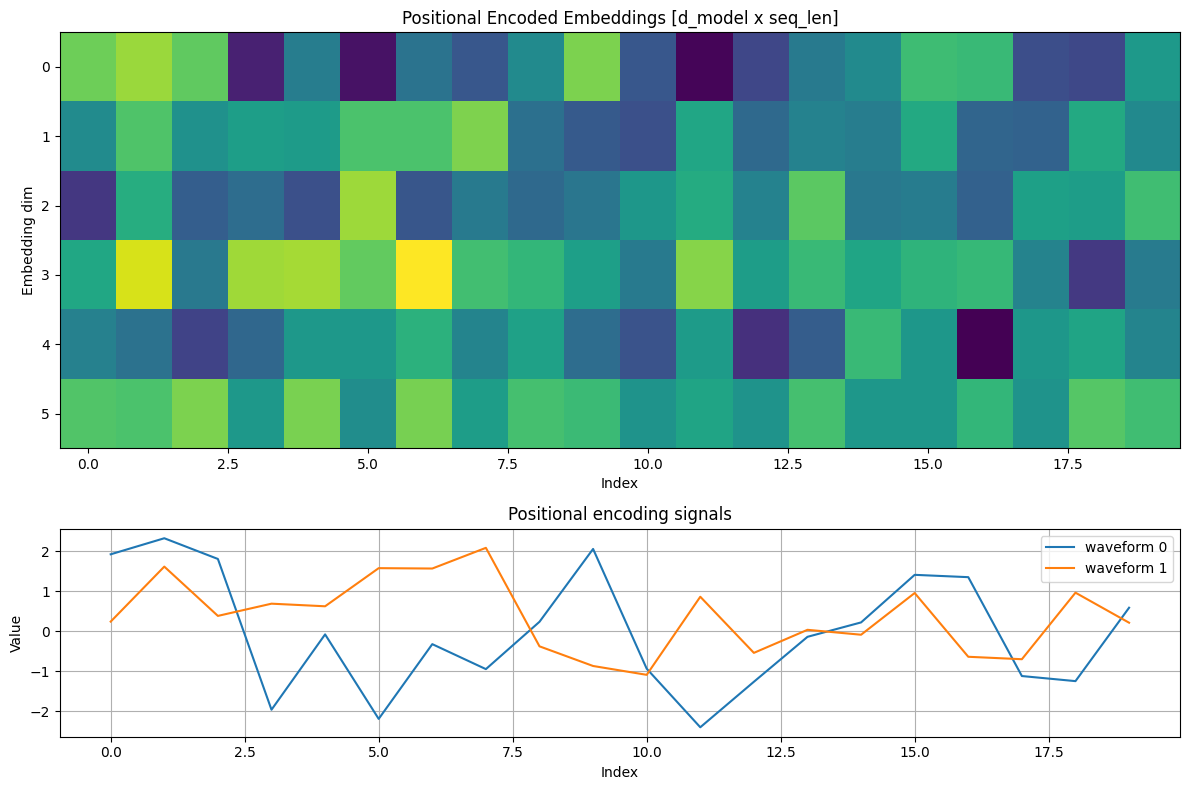

In [5]:
batch_size = 1
sequence_length = 20
embed_dim = 6
data = torch.randn(batch_size, embed_dim, sequence_length)   # [B, d_model, window_len]

# permute to transformer shape
data_tr = data.permute(2, 0, 1)   # [window_len, B, d_model]

pos_encoder = PositionalEncoding(embed_dim)
output = pos_encoder(data_tr)

# take batch=0, permute back to [d_model, seq_len] for plotting
output = output[:, 0, :].detach().T   # [d_model, seq_len]

# --- Plot ---
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(12, 8), gridspec_kw={'height_ratios':[2,1]})

ax0.imshow(output, aspect='auto', cmap='viridis')
ax0.set_title("Positional Encoded Embeddings [d_model x seq_len]")
ax0.set_ylabel("Embedding dim")
ax0.set_xlabel("Index")

# Plot one embedding dimension across sequence
ax1.plot(output[0].numpy(), label="waveform 0")
ax1.plot(output[1].numpy(), label="waveform 1")
ax1.legend()
ax1.set_title("Positional encoding signals")
ax1.set_xlabel("Index")
ax1.set_ylabel("Value")
ax1.grid(True)

plt.tight_layout()
plt.show()

### Try to Train

In [6]:
# Doing the training yuhh
from transformer import *
from utils import *
import torch.optim as optim
import wandb

epochs = 10
device = 'cuda'

# try tracking with wandb
logger = wandb.init(
    project="transformer_grid",
    name="lambda_0.1_poisson_log_part2",
    config={
        "epochs": epochs,
        "batch_size": batch_size,
        "lr": 1e-4,
    }
)

model = TransformerModel()
model.to(device)
# wandb.watch(model, log="all", log_freq=100)

optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-6)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

mode = 'mined_bce'
# results = train_model_2(model, train_loader, val_loader, scheduler, optimizer, device, epochs, mode, logger)
# wandb.finish()
# torch.save({
#     'model_state_dict': model.state_dict(),
#     'optimizer_state_dict': optimizer.state_dict(),
#     'scheduler_state_dict': scheduler.state_dict(),
# }, f"/sdf/home/c/carsmith/sdf_data/flash_detection_data/delay_200ks_ckpts/transformer_2_2_50.pth")

wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: carsmith (carsmith-stanford-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


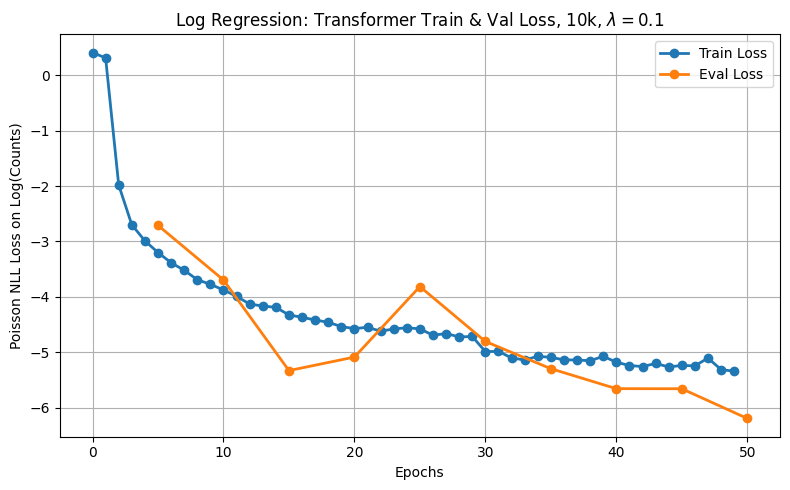

In [7]:
val_epochs = np.arange(len(results['eval_loss'])) * 5 + 5
plt.figure(figsize=(8, 5))
plt.plot(results['train_loss'], linewidth=2, marker='o', label='Train Loss')
plt.plot(val_epochs, results['eval_loss'], linewidth=2, marker='o', label='Eval Loss')
plt.xlabel("Epochs")
plt.ylabel("Poisson NLL Loss on Log(Counts)")
plt.title(r"Log Regression: Transformer Train & Val Loss, 10k, $\lambda=0.1$")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Instantiating from a Checkpoint
checkpoint = torch.load(f"/sdf/home/c/carsmith/sdf_data/flash_detection_data/delay_200ks_ckpts/transformer_28_80.pth", weights_only=False)
print(checkpoint.keys())
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-6)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
start_epoch = 80 + 1

# logger = wandb.init(
#     project="transformer_grid",
#     name="lambda_0.1_poisson_log_part2",
#     config={
#         "epochs": epochs,
#         "batch_size": batch_size,
#         "lr": 1e-4,
#     }
# )
logger = wandb.init(
    project="transformer_grid",
    name="lambda_0.1_poisson_log_part2",
    id="28ozznz1",   # <- put the real run ID here
    resume="must"
)

more_epochs = 50
more_results = train_model_2(model, train_loader, val_loader, scheduler, optimizer, device, more_epochs, mode, logger)
wandb.finish()
# torch.save({
#     'model_state_dict': model.state_dict(),
#     'optimizer_state_dict': optimizer.state_dict(),
#     'scheduler_state_dict': scheduler.state_dict(),
# }, "transformer_overtrain_norm200.pth")

dict_keys(['model_state_dict', 'optimizer_state_dict', 'scheduler_state_dict'])


Epoch 1/50:   6%|▌         | 441/7200 [00:29<06:54, 16.30it/s, train_loss=-5.85, train_acc=0.962, train_pure=0.0418]

In [ ]:
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
}, "/sdf/home/c/carsmith/sdf_data/flash_detection_data/delay_200ks_ckpts/transformer_28_130.pth")

In [ ]:
model.eval()
device = 'cuda'
train_progress = tqdm(val_loader, leave=False, position=0)
for i, (data, target, hit_times, photon_target, photon_list) in enumerate(train_progress):
    data, target, hit_times, photon_target = data.to(device), target.to(device), hit_times.to(device), photon_target.to(device) # model output is [25, 992] but target is [25, 1000] due to mismatch in downsampling/upsampling shapes
    class_output, reg_output = model(data)
    print(class_output.shape)
    break

epoch = 6
loss, sampled_indices, masked_target, masked_output, output, target, masked_reg_output, masked_photon_target = mined_bce_loss(data, hit_times, photon_list, class_output, reg_output, epoch, device)

In [ ]:
# Visualizing validation targets
# Inspecting Sampled Bins
waveform_id = 2
plt.figure(figsize=(15, 5))
plt.plot(masked_target[waveform_id*608:waveform_id*(608)+608].cpu(), marker='o', label='target')
plt.plot(torch.sigmoid(masked_output[waveform_id*608:waveform_id*(608)+608]).detach().cpu(), marker='x', alpha=0.8, label='pred w/ sigmoid')

hit_idx = hit_times[3].int()
mask = sampled_indices[3].cpu()
sampled_locs = torch.nonzero(mask).squeeze()
true_hit_locs_in_masked = [i for i, idx in enumerate(sampled_locs) if idx.item() in hit_idx.tolist()]

print("Hit times:", hit_idx.tolist())
print("Sampled indices:", sampled_locs.tolist())
print("True hit indices within masked:", true_hit_locs_in_masked)

indices = torch.nonzero(sampled_indices.cpu()[3] == True).squeeze().tolist()
# plt.xticks(ticks=range(len(indices)), labels=indices)
plt.xticks(ticks=range(len(indices)))


plt.xlabel('sampled bins from one time window')
plt.ylabel('value')
plt.axhline(0.5, linestyle='--', color='r', label='reg bin cutoff')
plt.title('Sampled Bins For 1 Time Window')
plt.legend()
plt.show()

In [ ]:
waveforms, arrival_times, hit_times, photon_bins, photon_list = next(iter(val_loader))
data, target, hit_times, photon_target, photon_list
model.eval()
class_output, reg_output = model(waveforms.to(device))

print(f"hit_times: {hit_times.shape}")
print(waveforms.shape)
print(arrival_times.shape)
ticks = np.arange(waveforms[0].shape[1])

waveform_id = 3
wf = waveforms[waveform_id]

ticks = torch.arange(wf.shape[-1])  # assume ticks = [0, 1, ..., length-1]
wf = wf.squeeze(0)  # shape: [length]

plt.plot(ticks, wf, alpha=1, label='Waveform')

# FOR MULTIPLE HITS!
for j, t in enumerate(hit_times[waveform_id]):
    if t < 0:
        pass
    else:
        plt.axvline(
            x=t.item(), 
            color='r', 
            linestyle='--', 
            linewidth=1, 
            label='True arrival' if j == 0 else ""
        )

class_output = class_output.squeeze(1)
print(class_output.shape)
mask = torch.sigmoid(class_output[waveform_id, :]) > 0.5   # shape [hits_per_batch]
print(f"mask shape {mask.shape}")

pred_hits = torch.nonzero(mask, as_tuple=False).squeeze(1) # shape [num_preds]
print(pred_hits.shape)
for j, t in enumerate(pred_hits):
    plt.axvline(
        x=t.item(),
        color='g',
        linestyle='--',
        linewidth=1,
        label='Pred arrival' if j == 0 else ""
    )

plt.title(f"Full Waveform")
plt.xlabel(f"Time Tick, 1 tick = 0.001 us")
plt.ylabel("ADC")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(15, 12), sharex=True)

# ------------------------------
# Plot 1: Full waveform with true + predicted hits
# ------------------------------
waveform_batch_id=2
wf = waveforms[waveform_batch_id]
ticks = torch.arange(wf.shape[-1])  # assume ticks = [0, 1, ..., length-1]
wf = wf.squeeze(0)  # shape: [length]
axes[0].plot(ticks, wf.cpu(), alpha=1, label='Waveform')

# True hits
for j, t in enumerate(hit_times[waveform_batch_id]):
    axes[0].axvline(
        x=int(t.item()), 
        color='r', 
        linestyle='--', 
        linewidth=2, 
        label='True arrival' if j == 0 else ""
    )

# Predicted hits
class_output = class_output.squeeze(1)
mask = torch.sigmoid(class_output[waveform_batch_id, :]) > 0.5
pred_hits = torch.nonzero(mask, as_tuple=False).squeeze(1)
# for j, t in enumerate(pred_hits):
#     axes[0].axvline(
#         x=t.item(),
#         color='g',
#         linestyle='--',
#         linewidth=2,
#         label='Pred arrival' if j == 0 else ""
#     )
    
axes[0].set_title("Full Waveform")
axes[0].set_ylabel("ADC", fontsize=12)
axes[0].legend()
axes[0].tick_params(axis='y', labelsize=12)
axes[0].grid(True)

# ------------------------------
# Plot 2: Sampled bins for Classification Loss
# ------------------------------
num_samples_per_wf = sampled_indices.sum(dim=1)
cum_samples = torch.cumsum(num_samples_per_wf, dim=0)   # [batch_size]
starts = torch.cat([torch.tensor([0], device=cum_samples.device), cum_samples[:-1]])
start = starts[waveform_batch_id].item()
end   = cum_samples[waveform_batch_id].item()

sampled_locs = torch.nonzero(sampled_indices[waveform_batch_id].cpu()).squeeze().tolist()
idx_tensor   = torch.tensor(sampled_locs, dtype=torch.long)

# Safe indexing (move to CPU first)
# y_target = masked_target[waveform_batch_id*608 : waveform_batch_id*608 + 608].cpu() # contents are 0-1 values, but have 1-1 correspondance with indices in idx_tensor
# y_pred   = torch.sigmoid(masked_output[waveform_batch_id*608 : waveform_batch_id*608 + 608]).cpu().detach() # contents are probabilities, but have 1-1 correspondance with indices in idx_tensor
y_target = masked_target[start:end].cpu()
y_pred   = torch.sigmoid(masked_output[start:end]).cpu().detach()

print("shapes: ", idx_tensor.shape, y_target.shape, y_pred.shape)
axes[1].scatter(idx_tensor, y_target, marker='o', label='target')
axes[1].scatter(idx_tensor, y_pred, marker='x', alpha=1.0, label='pred w/ sigmoid')

# True hit bin indices
hit_idx = hit_times[waveform_batch_id].int().tolist()

# All sampled bin indices (e.g. [3, 8, 15, ...])
start_bins = []
end_bins = []

for h in hit_idx:
    start_bins.append(h)
    candidates = [loc for loc in sampled_locs if h <= loc <= h+900]
    if candidates:
        end_bin = max(candidates)  # furthest one within 20ns
    else:
        end_bin = h  # fallback: no sampled loc in range
    end_bins.append(end_bin)

# --- merge overlaps ---
intervals = sorted(zip(start_bins, end_bins), key=lambda x: x[0])
merged = []
for s, e in intervals:
    if merged and s <= merged[-1][1]:  # overlaps last interval
        merged[-1][1] = max(merged[-1][1], e)
    else:
        merged.append([s, e])

# --- plot only merged spans ---
for j, (s_bin, e_bin) in enumerate(merged):
    axes[1].axvspan(s_bin, e_bin, facecolor='lightcoral', alpha=0.3,
                    zorder=-1, label="Within 900ns of an Event" if j == 0 else None)

axes[1].set_ylabel('Sigmoid Value', fontsize=12)
axes[1].axhline(0.5, linestyle='--', color='r', label='reg bin cutoff')
axes[1].set_title('Classification Loss: Sampled Bins')
axes[1].legend()
axes[1].set_xlim(axes[0].get_xlim())
axes[1].tick_params(axis='y', labelsize=12)
axes[1].grid(True)

# ------------------------------
# Plot 3: Sampled photon counts 
# ------------------------------
# How to keep track of regression indices in each waveform - class_output > 0.5 for each sample
mask = torch.sigmoid(class_output) > 0.5
regressions_per_wf = mask.sum(dim=1)

photon_idx = (torch.sigmoid(class_output[waveform_batch_id]) > 0.5).nonzero(as_tuple=False).squeeze(1).detach().cpu()

start = torch.sum(regressions_per_wf[:waveform_batch_id]).item()
end   = torch.sum(regressions_per_wf[:waveform_batch_id + 1]).item()

axes[2].plot(
    photon_idx,
    masked_photon_target[start:end].cpu(),
    marker='o', label='target'
)
axes[2].plot(
    photon_idx,
    torch.exp(masked_reg_output[start:end]).detach().cpu(),
    marker='o', label='pred'
)

axes[2].set_xlabel("Time Tick (1 tick = 0.001 us)", fontsize=12)
axes[2].set_ylabel('Number of Photons', fontsize=12)
axes[2].set_title('Regression Loss: On All Predicted Hits')
axes[2].tick_params(axis='x', labelsize=12)  # x ticks
axes[2].tick_params(axis='y', labelsize=12)
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.show()

In [15]:
print(torch.nonzero(sampled_indices[2], as_tuple=False).shape)

torch.Size([605, 1])


In [16]:
num_samples_per_wf = sampled_indices.sum(dim=1)
print(num_samples_per_wf)

tensor([608, 607, 605, 608, 604, 602, 602, 602, 604, 607, 605, 606, 605, 602,
        605, 606, 606, 604, 605, 602, 604, 602, 608, 602, 605],
       device='cuda:0')


In [ ]:
bin_width = 100
batches_per_photon = 400

# Put models into a dict
models = {
    "tr": transformer_130,
    "unet": unet_50
    # "myother": my_other_model,
}

# Initialize results dict: each model gets its own metrics
results = {
    name: {"reco_frac_flash1": [], "reco_frac_flash2": [], "merge_acc_flash1": [], "merge_acc_flash2": [], "merge_pure": []}
    for name in models.keys()
}

epochs = 1

for epoch in range(epochs):
    acc_progress = tqdm(
        delta_loader,
        desc=f"Scanning {epoch+1}/{epochs}",
        leave=False,
        position=0
    )

    # Temporary accumulators for per-photon-bin averages
    reco_frac_flash1 = {name: 0.0 for name in models.keys()}
    reco_frac_flash2 = {name: 0.0 for name in models.keys()}
    merge_acc_flash1 = {name: 0.0 for name in models.keys()}
    merge_acc_flash2 = {name: 0.0 for name in models.keys()}
    merge_pure = {name: 0.0 for name in models.keys()}

    with torch.no_grad():
        for i, (data, target, hit_times, photon_target, photon_list) in enumerate(acc_progress):
            data, target, photon_target = data.to(device), target.to(device), photon_target.to(device)

            # loop through all models
            for name, model in models.items():
                if name == "tr":
                    class_output, reg_output = model(data, mode="bce")
                else:
                    class_output, reg_output = model(data)

                merged_mask = merge_bins(class_output, skip_tol=5)

                # Summed Photons per Interval
                interval_pred_sums = sum_photons_in_intervals(torch.exp(reg_output), merged_mask)
                interval_true_sums = sum_photons_in_intervals(photon_target, merged_mask)

                pred = torch.tensor([np.sum(x) for x in interval_pred_sums])
                true = torch.tensor([np.sum(x) for x in interval_true_sums])
                mask = true > 0
                # if mask.any():
                if mask.sum() >= 2:  # make sure at least two flashes survived got detected
                    valid_idx = torch.where(mask)[0]
                    reco_frac_flash1[name] += (pred[valid_idx[0]] / true[valid_idx[0]]).item()
                    reco_frac_flash2[name] += (pred[valid_idx[1]] / true[valid_idx[1]]).item()
                    # reco_frac[name] += torch.mean(pred[mask] / true[mask]).item() # average

                # Merging metrics
                flash1_acc, flash2_acc = merged_twoflash_acc(merged_mask, hit_times, device)
                merge_acc_flash1[name] += flash1_acc
                merge_acc_flash2[name] += flash2_acc

                merge_pure[name] += merged_class_purity(merged_mask, hit_times, device)

            # Record stats once per photon bin
            if (i + 1) % batches_per_photon == 0:
                for name in models.keys():
                    reco_frac_flash1[name] /= batches_per_photon
                    reco_frac_flash2[name] /= batches_per_photon
                    merge_acc_flash1[name] /= batches_per_photon
                    merge_acc_flash2[name] /= batches_per_photon
                    merge_pure[name] /= batches_per_photon

                    results[name]["reco_frac_flash1"].append(reco_frac_flash1[name])
                    results[name]["reco_frac_flash2"].append(reco_frac_flash2[name])
                    results[name]["merge_acc_flash1"].append(merge_acc_flash1[name])
                    results[name]["merge_acc_flash2"].append(merge_acc_flash2[name])
                    results[name]["merge_pure"].append(merge_pure[name])

                    # reset accumulators
                    reco_frac_flash1[name] = 0.0
                    reco_frac_flash2[name] = 0.0
                    merge_acc_flash1[name] = 0.0
                    merge_acc_flash2[name] = 0.0
                    merge_pure[name] = 0.0

np.save("test_ratiostats.npy", results, allow_pickle=True)